# Betting Framework

In this notebook, I am evaluating the score prediction models versus the betting odds of bookmakers. I identify the best betting opportunity (the one with the highest expected value) and then place a bet using risk management: using the Kelly criterion, I am riding the maximum growth curve.

In [1]:
import pandas as pd
import numpy as np

Here I use *Bet365* as the benchmark bookmaker.

In [2]:
odds_market = (
    pd.read_csv('../data/betting/2021-22.csv')
    .loc[:, ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "B365H", "B365D", "B365A"]]
    .rename(columns={
        "HomeTeam": "team1",
        "AwayTeam": "team2",
        "FTHG": "score1",
        "FTAG": "score2",
        "B365H": "home_win",
        "B365D": "draw",
        "B365A": "away_win"})
)

odds_market = odds_market.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man United': 'Manchester United',
    'Norwich': 'Norwich City',
    'Tottenham': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [3]:
# Get the model predictions.
outcome = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
outcome = (outcome
           .loc[(outcome['league_id'] == 2411) | (outcome['league_id'] == 2412)]
           .dropna()
           )

predictions_dixon_coles = (
    pd.merge(
        pd.read_csv("../data/predictions/scores/dixon_coles.csv"),
        outcome.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
).dropna()

predictions_spi = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
predictions_spi = (
    predictions_spi
    .loc[predictions_spi['league_id'] == 2411]
    .rename(columns={
        "prob1": "home_win_p",
        "probtie": "draw_p",
        "prob2": "away_win_p"})
    .loc[:, ['team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p', 'score1', 'score2']]
    .loc[predictions_spi['season'] == 2021]
    .loc[predictions_spi['score1'].notna()]
    )

In [4]:
df = (
    pd.merge(
        predictions_dixon_coles.loc[:, ['team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        # predictions_spi.loc[:, ['team1', 'team2', 'home_win_p', 'draw_p', 'away_win_p']],
        odds_market,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2'])
    .dropna()
    )

In [6]:
def excepted_value(p_win, gain):
    return p_win * gain - (1 - p_win) * 0

df['ev_h'] = df.apply(lambda row: excepted_value(row['home_win_p'], row['home_win']), axis=1)
df['ev_d'] = df.apply(lambda row: excepted_value(row['draw_p'], row['draw']), axis=1)
df['ev_a'] = df.apply(lambda row: excepted_value(row['away_win_p'], row['away_win']), axis=1)

In [5]:
def kelly_criterion(p, q):
    return p + (p - 1) / (q - 1)

df['k_h'] = df.apply(lambda row: kelly_criterion(row['home_win_p'], row['home_win']), axis=1)
df['k_d'] = df.apply(lambda row: kelly_criterion(row['draw_p'], row['draw']), axis=1)
df['k_a'] = df.apply(lambda row: kelly_criterion(row['away_win_p'], row['away_win']), axis=1)

In [8]:
from ranked_probability_score import match_outcome

df['winner'] = match_outcome(df)

In [9]:
account_balance = 100

def bet(row):
    global account_balance

    # Get highest potential event
    evs = np.array([row['ev_h'], row['ev_d'], row['ev_a']])
    edge = np.argmax(evs)

    # Ensure its profitable
    if evs[edge] > 1:
        
        # Get bet amount
        k = np.array([row['k_h'], row['k_d'], row['k_a']])[edge]
        
        # Ensure we bet a positive amount
        if k > 0:
            bet_value = k * account_balance
            account_balance -= bet_value

            # Get result of the bet
            if edge == row['winner'] == 0:
                account_balance += bet_value * row['home_win']

            elif edge == row['winner'] == 1:
                account_balance += bet_value * row['draw']

            elif edge == row['winner'] == 2:
                account_balance += bet_value * row['away_win']

    return account_balance
    
df['balance'] = df.apply(bet, axis=1)

Well, it turns out that my model is not yet ready to beat the odds. 🤣

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

Text(0.8, 0.01, 'Created by Paul Fournier')

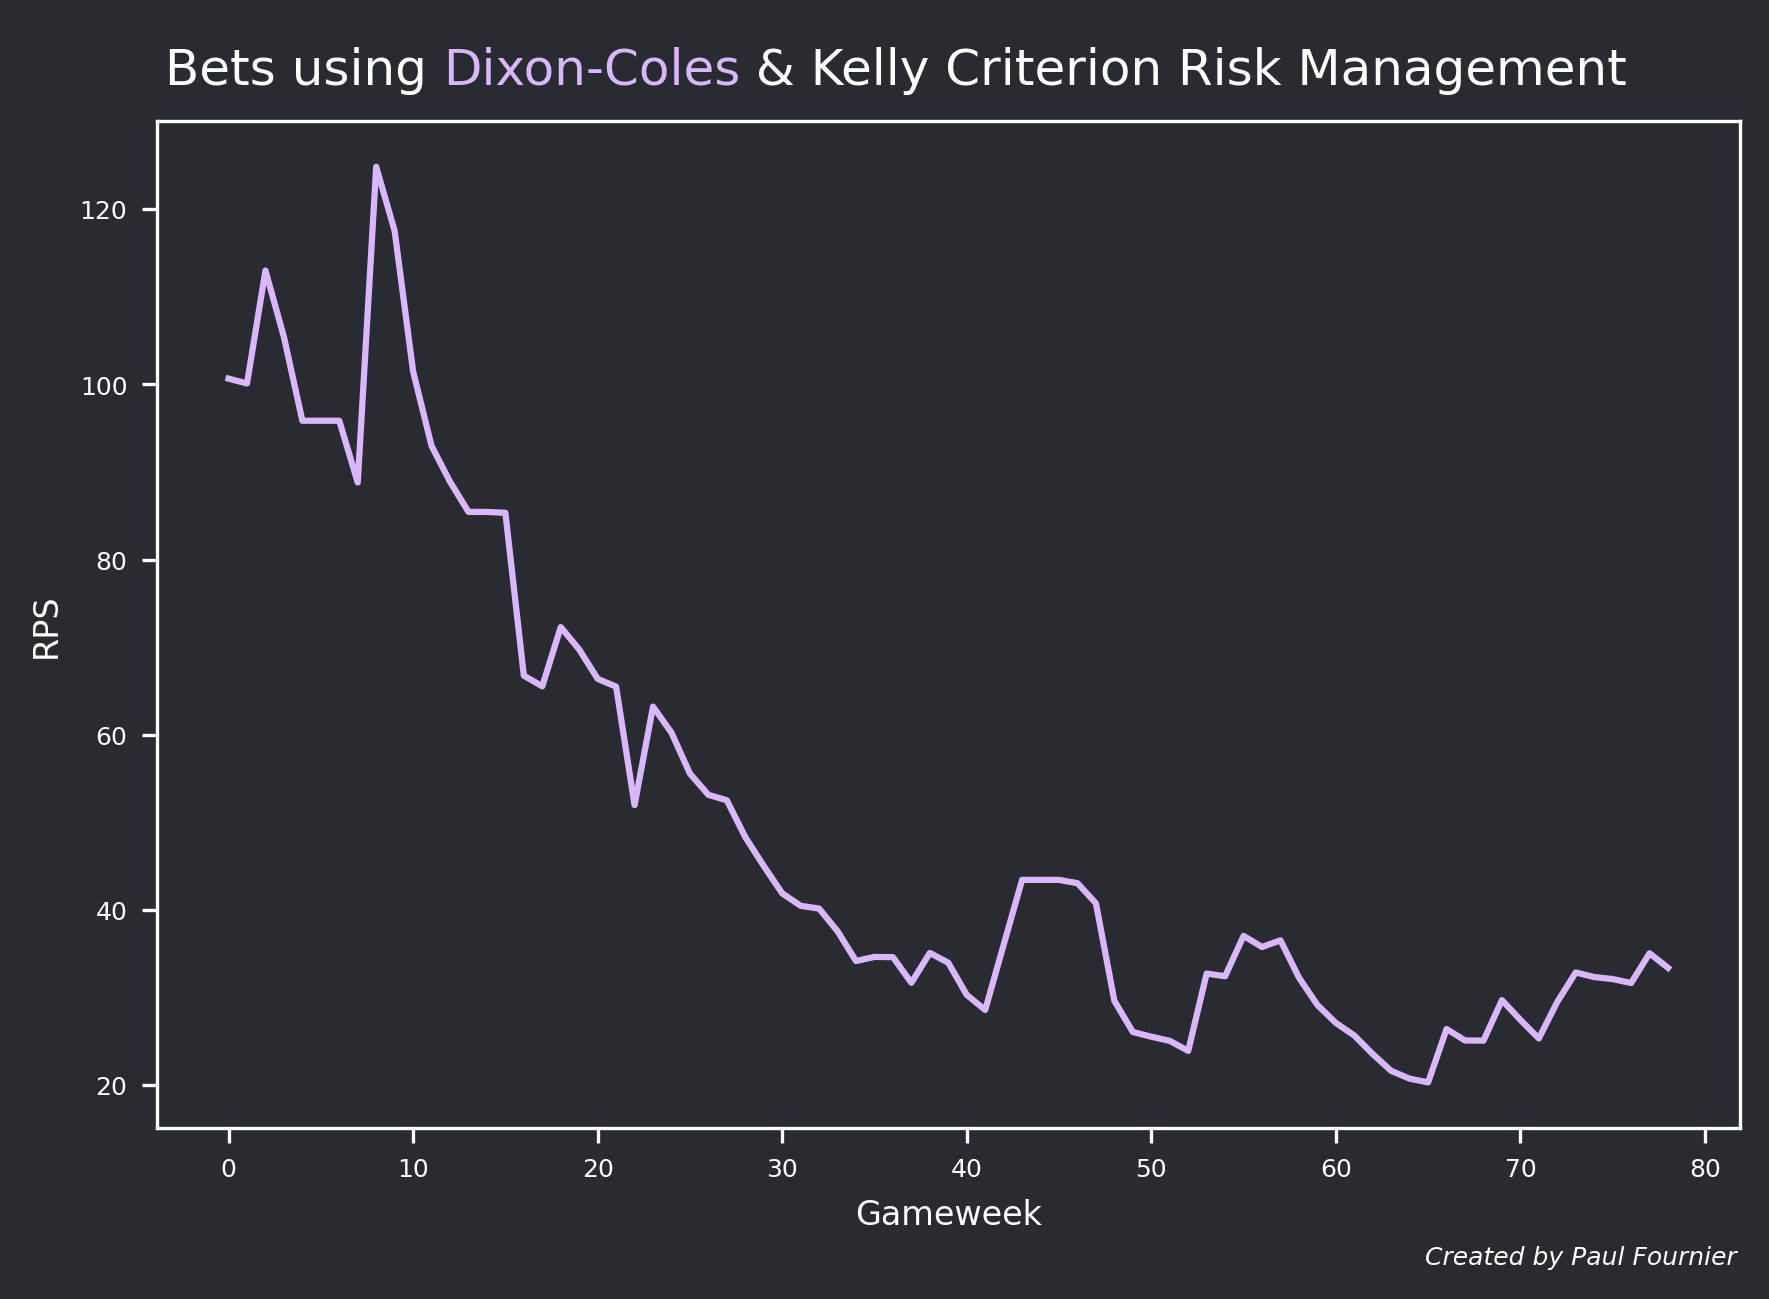

In [16]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    df['balance'],
    color='#dab6fc')

ax.set_xlabel('Gameweek', fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

# fig_text(x=0.08, y=1.075,
#         s="Ranked Probability Score for <Poisson>, <Dixon-Coles>, <Bayesian>,",
#         highlight_textprops=[
#             {"color": '#b7094c'},
#             {"color": '#892b64'},
#             {"color": '#5c4d7d'},
#             ],
#         fontweight="regular", fontsize=12, fontfamily=title_font,
#         color=text_color, alpha=1)

fig_text(x=0.1, y=1.025,
        s="Bets using <Dixon-Coles> & Kelly Criterion Risk Management",
        highlight_textprops=[
            {"color": '#dab6fc'}
            ],
        fontweight="regular", fontsize=12, fontfamily=title_font,
        color=text_color, alpha=1)

fig.text(
    0.8, 0.01, "Created by Paul Fournier",
    fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)